In [21]:
import pandas as pd
import seaborn as sns
from glob import glob
import os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
import metaprofile_across_regions as mar

In [22]:
# Files
coverage_files = glob('../../../results/Metaprofiles/Lin28aAroundPabpc/**/*_unsmoothed*.tsv')

# Sample annotation
annot = pd.read_csv('../../../data/general/SampleAnnotation.csv', index_col=0)

# Save to
outpath = '../../../results/Metaprofiles/Lin28aAroundPabpc/plots'
os.makedirs(outpath, exist_ok=True)

# Parameters
sw = 20 # Smoothin window

In [23]:
def smoothDf(df, sw):
    cols = [c for c in df.columns.tolist() if c in ['ciMax', 'ciMin', 'mean']]
    df[cols] = df[cols].rolling(sw, center=True,  win_type='triang', axis=0).mean()\
                    .fillna(axis=0, method='ffill')\
                    .fillna(axis=0, method='bfill')
    return df

In [24]:
coverage_files[0]

'../../../results/Metaprofiles/Lin28aAroundPabpc/pabpc4_three_prime_cond-S200WT_2iL/coverage_unsmoothed_norm-by_reg.tsv'

In [25]:
# Combine into one table
dfList = []
for f in coverage_files:
    df = pd.read_csv(f, sep='\t')
    df['Region'] = f.split('/')[-2].split('_cond')[0].split('_', 1)[-1]
    df['Peaks'] = f.split('/')[-2].split('_')[0].upper()
    df['Condition'] = f.split('/')[-2].split('cond-')[-1]
    df['Norm'] = f.split('/')[-1].split('norm-')[-1].split('.')[0]
    dfList.append(df)
dfCombined = pd.concat(dfList)

In [26]:
dfCombined.head()

,mean,ciMin,ciMax,Sample,Position,Region,Peaks,Condition,Norm
0,0.003456,0.003154,0.003757,LIN28A-WT_ESCiLIF_merged.bed.gz,-100,three_prime,PABPC4,S200WT_2iL,by_reg
1,0.003284,0.003031,0.003536,LIN28A-WT_ESCiLIF_merged.bed.gz,-99,three_prime,PABPC4,S200WT_2iL,by_reg
2,0.003346,0.003062,0.003629,LIN28A-WT_ESCiLIF_merged.bed.gz,-98,three_prime,PABPC4,S200WT_2iL,by_reg
3,0.003497,0.003081,0.003912,LIN28A-WT_ESCiLIF_merged.bed.gz,-97,three_prime,PABPC4,S200WT_2iL,by_reg
4,0.003233,0.002960,0.003507,LIN28A-WT_ESCiLIF_merged.bed.gz,-96,three_prime,PABPC4,S200WT_2iL,by_reg


In [27]:
# Smooth with a desired window
dfCombined = dfCombined.groupby(['Sample', 'Condition', 'Norm', 'Region', 'Peaks']).apply(smoothDf, sw=sw)

In [28]:
# Annotate samples
dfCombined = dfCombined.merge(annot, on=['Sample', 'Condition'], how='left')
dfCombined.head()

,mean,ciMin,ciMax,Sample,Position,Region,Peaks,Condition,Norm,Protein,Experiment
0,0.003986,0.003738,0.004233,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-100,five_prime,PABPC1,S200A_FCL,by_reg,LIN28A,FLAG-IP LIN28A – merged
1,0.003986,0.003738,0.004233,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-99,five_prime,PABPC1,S200A_FCL,by_reg,LIN28A,FLAG-IP LIN28A – merged
2,0.003986,0.003738,0.004233,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-98,five_prime,PABPC1,S200A_FCL,by_reg,LIN28A,FLAG-IP LIN28A – merged
3,0.003986,0.003738,0.004233,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-97,five_prime,PABPC1,S200A_FCL,by_reg,LIN28A,FLAG-IP LIN28A – merged
4,0.003986,0.003738,0.004233,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-96,five_prime,PABPC1,S200A_FCL,by_reg,LIN28A,FLAG-IP LIN28A – merged


('by_reg', 'five_prime')
('by_reg', 'three_prime')
('libsize', 'five_prime')
('libsize', 'three_prime')


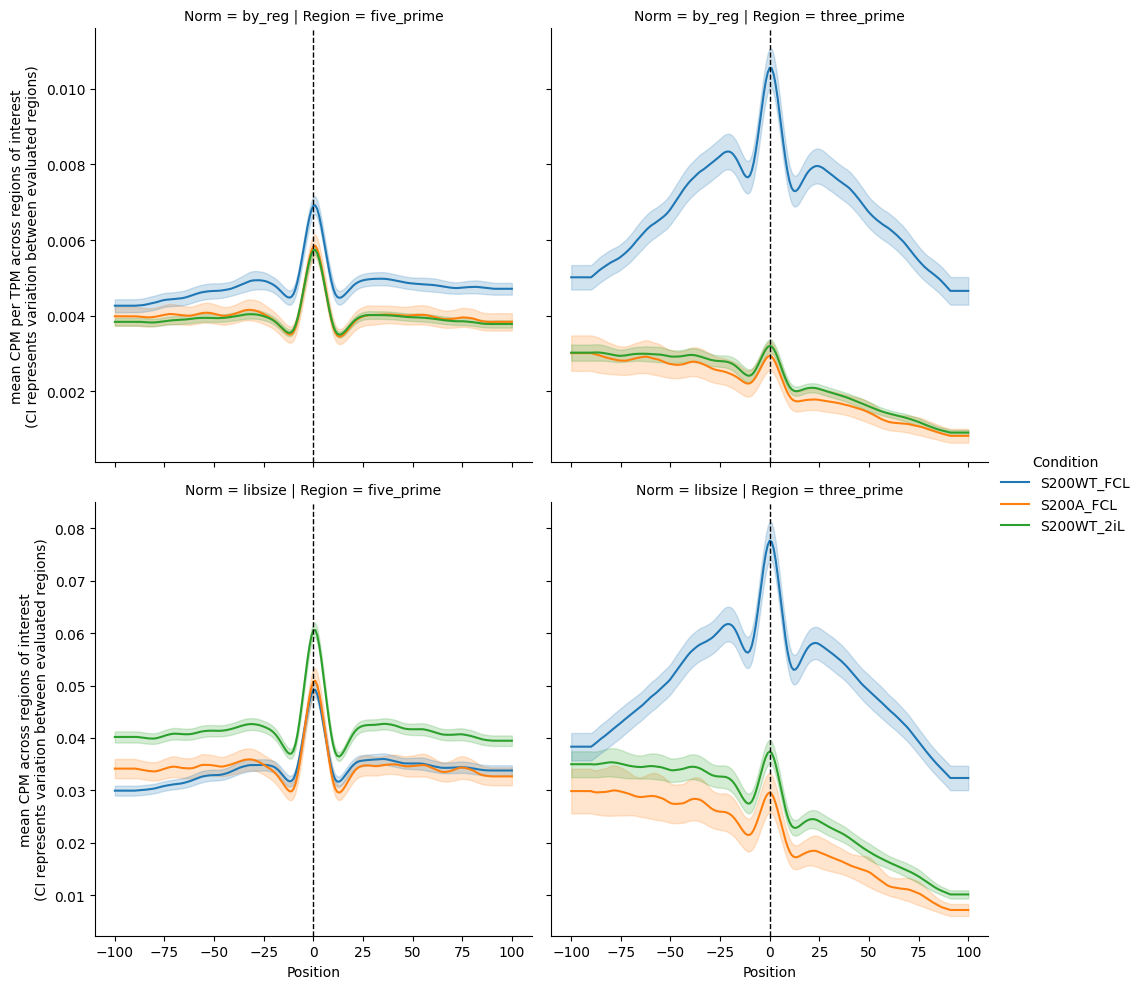

In [31]:
# Plot
dfPlot = dfCombined.loc[dfCombined.Peaks == 'PABPC1']
hue_order = ['S200WT_FCL', 'S200A_FCL', 'S200WT_2iL']
colorMap = {sample: sns.color_palette('tab10', len(hue_order))[i] for i, sample in enumerate(hue_order)}

g = sns.relplot(
    data=dfPlot, x='Position', y='mean', hue='Condition',
    kind='line', col='Region', row='Norm', facet_kws={'sharey': 'row', 'sharex': True},
    hue_order=hue_order, palette=colorMap
    )

for idx, ax in g.axes_dict.items():
    print(idx)
    df = dfPlot.loc[(dfPlot['Norm'] == idx[0]) & (dfPlot['Region']==idx[1])]
    ax.axvline(0, color='black', ls='dashed', lw=1)
    for line_ids, dft in df.groupby('Condition'):
        ax.fill_between(dft.Position, dft.ciMin, dft.ciMax, alpha=0.2, color=colorMap[line_ids])
        if idx[0] == 'libsize':
            ax.set_ylabel('mean CPM across regions of interest\n(CI represents variation between evaluated regions)')
        else:
            ax.set_ylabel('mean CPM per TPM across regions of interest\n(CI represents variation between evaluated regions)')
g.fig.savefig(f'{outpath}/LIN28A_around_PABPC1_peaks_metaprofiles.pdf', bbox_inches='tight')

('by_reg', 'five_prime')
('by_reg', 'three_prime')
('libsize', 'five_prime')
('libsize', 'three_prime')


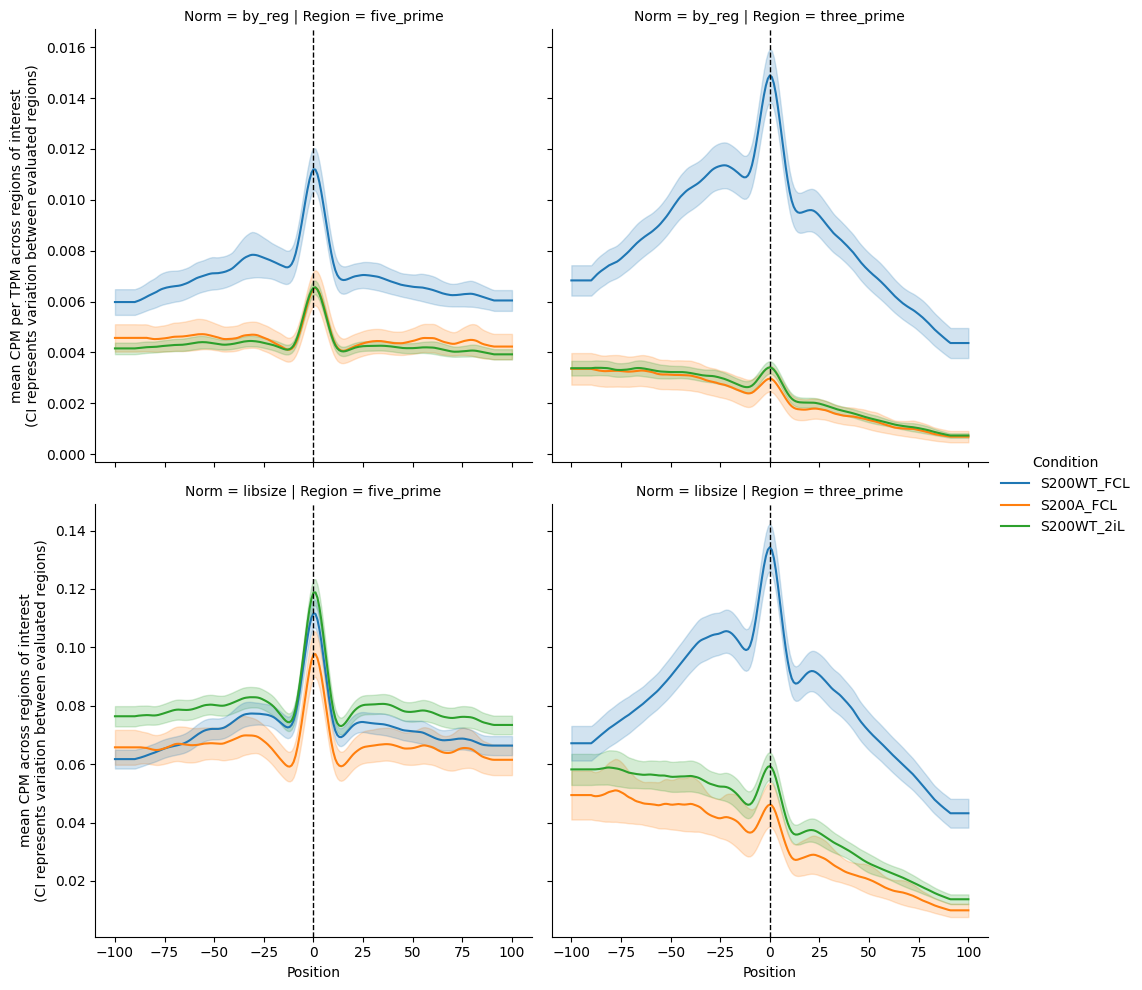

In [32]:
# Plot
dfPlot = dfCombined.loc[dfCombined.Peaks == 'PABPC4']
hue_order = ['S200WT_FCL', 'S200A_FCL', 'S200WT_2iL']
colorMap = {sample: sns.color_palette('tab10', len(hue_order))[i] for i, sample in enumerate(hue_order)}

g = sns.relplot(
    data=dfPlot, x='Position', y='mean', hue='Condition',
    kind='line', col='Region', row='Norm', facet_kws={'sharey': 'row', 'sharex': True},
    hue_order=hue_order, palette=colorMap
    )

for idx, ax in g.axes_dict.items():
    print(idx)
    df = dfPlot.loc[(dfPlot['Norm'] == idx[0]) & (dfPlot['Region']==idx[1])]
    ax.axvline(0, color='black', ls='dashed', lw=1)
    for line_ids, dft in df.groupby('Condition'):
        ax.fill_between(dft.Position, dft.ciMin, dft.ciMax, alpha=0.2, color=colorMap[line_ids])
        if idx[0] == 'libsize':
            ax.set_ylabel('mean CPM across regions of interest\n(CI represents variation between evaluated regions)')
        else:
            ax.set_ylabel('mean CPM per TPM across regions of interest\n(CI represents variation between evaluated regions)')
g.fig.savefig(f'{outpath}/LIN28A_around_PABPC4_peaks_metaprofiles.pdf', bbox_inches='tight')